In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import warnings
warnings.filterwarnings('ignore')
import tensorflow as tf
tf.random.set_seed(42)
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Input, Dense, Normalization
from sklearn.utils import class_weight
from sklearn.metrics import precision_score, recall_score, f1_score
from keras import backend as K
import keras_tuner as kt
from google.colab import files

In [6]:
df = pd.read_csv('diabetes.csv')
df_copy = df.drop(df[df['gender'] == 'Other'].index)
df_copy

,gender,age,hypertension,heart_disease,smoking_history,bmi,HbA1c_level,blood_glucose_level,diabetes
0,Female,80.0,0,1,never,25.19,6.6,140,0
1,Female,54.0,0,0,No Info,27.32,6.6,80,0
2,Male,28.0,0,0,never,27.32,5.7,158,0
3,Female,36.0,0,0,current,23.45,5.0,155,0
4,Male,76.0,1,1,current,20.14,4.8,155,0
...,...,...,...,...,...,...,...,...,...
99995,Female,80.0,0,0,No Info,27.32,6.2,90,0
99996,Female,2.0,0,0,No Info,17.37,6.5,100,0
99997,Male,66.0,0,0,former,27.83,5.7,155,0
99998,Female,24.0,0,0,never,35.42,4.0,100,0


# Create test set

In [7]:
X = df_copy.drop(columns='diabetes')
y = df_copy['diabetes'].copy()

In [8]:
X_train_full, X_test, y_train_full, y_test = train_test_split(X, y,
                                                    test_size=.2,
                                                    stratify=df_copy['diabetes'],
                                                    random_state=42)

X_train, y_train = X_train_full[:-7000], y_train_full[:-7000]
X_valid, y_valid = X_train_full[-7000:], y_train_full[-7000:]

In [9]:
X_train = pd.get_dummies(X_train)

In [10]:
X_valid = pd.get_dummies(X_valid)

# Sequential API

In [11]:
early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=15,
                                                     restore_best_weights=True,
                                                     verbose=1
                                                     )

In [12]:
model = tf.keras.Sequential([
    Input(shape=(14,), name='input_layer'),
    Normalization(),
    Dense(300, activation='relu', name='dense_layer_1'),
    Dense(100, activation='relu', name='dense_layer_2'),
    Dense(50, activation='relu', name='dense_layer_3'),
    Dense(25, activation='relu', name='dense_layer_4'),
    Dense(10, activation='relu', name='dense_layer_5'),
    Dense(1, activation='sigmoid', name='output_layer')
])

In [13]:
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=[tf.keras.metrics.Recall(), tf.keras.metrics.Precision()])

In [48]:
class_labels = [0, 1]
class_weights = class_weight.compute_class_weight('balanced',
                                                  classes=class_labels,
                                                  y=df_copy['diabetes'])
class_weights_dict = dict(zip(class_labels, class_weights))


In [14]:
history = model.fit(X_train, y_train, epochs=1000,
          validation_data=(X_valid, y_valid),
          class_weight={0: 2, 1: 5},
          callbacks=[early_stopping_cb])

Epoch 1/1000
2281/2281 [==============================] - 21s 5ms/step - loss: 0.5452 - recall: 0.3100 - precision: 0.4484 - val_loss: 0.2080 - val_recall: 0.4950 - val_precision: 0.5933
Epoch 2/1000
2281/2281 [==============================] - 11s 5ms/step - loss: 0.3463 - recall: 0.6244 - precision: 0.5836 - val_loss: 0.1271 - val_recall: 0.5497 - val_precision: 0.8579
Epoch 3/1000
2281/2281 [==============================] - 11s 5ms/step - loss: 0.2842 - recall: 0.6801 - precision: 0.6615 - val_loss: 0.1323 - val_recall: 0.6987 - val_precision: 0.7391
Epoch 4/1000
2281/2281 [==============================] - 12s 5ms/step - loss: 0.2639 - recall: 0.6887 - precision: 0.6899 - val_loss: 0.1864 - val_recall: 0.7964 - val_precision: 0.5491
Epoch 5/1000
2281/2281 [==============================] - 16s 7ms/step - loss: 0.2605 - recall: 0.6974 - precision: 0.6877 - val_loss: 0.1224 - val_recall: 0.6639 - val_precision: 0.7741
Epoch 6/1000
2281/2281 [==============================] - 12s 5ms

<Axes: >

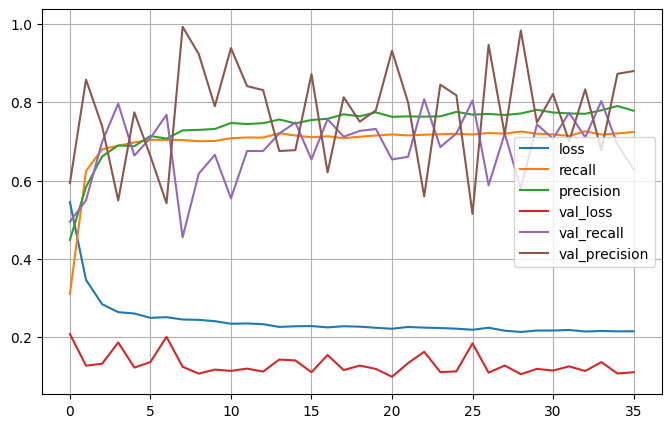

In [114]:
pd.DataFrame(history.history).plot(figsize=(8, 5), grid=True)

In [16]:
model.evaluate(pd.get_dummies(X_test), y_test)

625/625 [==============================] - 2s 3ms/step - loss: 0.0908 - recall: 0.6771 - precision: 0.9434


[0.09077893942594528, 0.6770588159561157, 0.9434426426887512]

In [73]:
!pip install -U keras-tuner

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 176.1/176.1 kB 4.0 MB/s eta 0:00:00


In [92]:
kthp = kt.HyperParameters
def build_model(hp: kthp):
  n_hidden = hp.Int('n_hidden', min_value=0,
                    max_value=10, default=2)

  n_neurons = hp.Int('n_neurons', min_value=16,
                     max_value=256)

  learning_rate = hp.Float('learning_rate', min_value=1e-5,
                           max_value=1e-2,
                           sampling='log')

  opt = hp.Choice('optimizer',
                        values=['sgd', 'adam', 'adamax', 'adafactor'])

  act = hp.Choice('activation',
                        values=['relu', 'gelu', 'selu', 'tanh'])

  if opt == 'sgd':
    opt = tf.keras.optimizers.SGD(learning_rate=learning_rate)
  elif opt == 'adam':
    opt = tf.keras.optimizers.Adam(learning_rate=learning_rate)
  elif opt == 'adafactor':
    opt = tf.keras.optimizers.Adafactor(learning_rate=learning_rate)
  else:
    opt = tf.keras.optimizers.Adamax(learning_rate=learning_rate)

  if act == 'relu':
    act = tf.keras.activations.relu
  elif act == 'selu':
    act = tf.keras.activations.selu
  elif act == 'gelu':
    act = tf.keras.activations.gelu
  else:
    act = tf.keras.activations.tanh

  model = tf.keras.Sequential()
  model.add(Input(shape=(14,)))
  for _ in range(n_hidden):
    model.add(tf.keras.layers.Dense(n_neurons, activation=act))
  model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

  model.compile(loss='binary_crossentropy',
              optimizer=opt,
              metrics=[tf.keras.metrics.Recall(), tf.keras.metrics.Precision(), f1_score])

  return model

In [87]:
def f1_score(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val

In [93]:
rand_search = kt.RandomSearch(
    build_model,
    objective=kt.Objective("f1_score", direction="max"),
    max_trials=15,
    overwrite=True, directory='diabetes_dataset', project_name='rnd_search',
    seed=42
)

In [94]:
rand_search.search(X_train, y_train, epochs=15,
                   validation_data=(X_valid, y_valid))

Trial 15 Complete [00h 03m 12s]
f1_score: 0.182085782289505

Best f1_score So Far: 0.6566755771636963
Total elapsed time: 00h 49m 37s


In [95]:
best3 = rand_search.get_best_models(num_models=3)
best_model = best3[0]
best_params = rand_search.get_best_hyperparameters(num_trials=2)[0].values
best_trials = rand_search.oracle.get_best_trials(num_trials=2)[0].summary()

Trial 07 summary
Hyperparameters:
n_hidden: 8
n_neurons: 212
learning_rate: 2.729031103694528e-05
optimizer: adam
activation: selu
Score: 0.6566755771636963


In [96]:
history_best = best_model.fit(X_train, y_train, epochs=1000,
          validation_data=(X_valid, y_valid),
          callbacks=[early_stopping_cb])

Epoch 1/1000
2281/2281 [==============================] - 25s 7ms/step - loss: 0.0991 - recall: 0.6265 - precision: 0.9418 - f1_score: 0.6637 - val_loss: 0.1088 - val_recall: 0.5778 - val_precision: 0.9721 - val_f1_score: 0.6310
Epoch 2/1000
2281/2281 [==============================] - 14s 6ms/step - loss: 0.0977 - recall: 0.6306 - precision: 0.9426 - f1_score: 0.6644 - val_loss: 0.1218 - val_recall: 0.5331 - val_precision: 1.0000 - val_f1_score: 0.5995
Epoch 3/1000
2281/2281 [==============================] - 18s 8ms/step - loss: 0.0986 - recall: 0.6288 - precision: 0.9498 - f1_score: 0.6558 - val_loss: 0.1119 - val_recall: 0.5828 - val_precision: 0.9972 - val_f1_score: 0.6420
Epoch 4/1000
2281/2281 [==============================] - 14s 6ms/step - loss: 0.0997 - recall: 0.6265 - precision: 0.9422 - f1_score: 0.6551 - val_loss: 0.1190 - val_recall: 0.6722 - val_precision: 0.8252 - val_f1_score: 0.6722
Epoch 5/1000
2281/2281 [==============================] - 14s 6ms/step - loss: 0.097

In [98]:
best_model.evaluate(pd.get_dummies(X_test), y_test)

625/625 [==============================] - 3s 5ms/step - loss: 0.0832 - recall: 0.6788 - precision: 0.9813 - f1_score: 0.7084


[0.08324974030256271,
 0.6788235306739807,
 0.9812925457954407,
 0.7084188461303711]

In [103]:
preds = model.predict(pd.get_dummies(X_test))

625/625 [==============================] - 2s 4ms/step


In [119]:
threshold = .39
print(precision_score(y_test.to_numpy(), np.where(preds > threshold, 1, 0)))
print(recall_score(y_test.to_numpy(), np.where(preds > threshold, 1, 0)))

0.8492392807745505
0.7223529411764706


In [123]:
model.save('74_recall', save_format='tf')
directory_path = '/content/74_recall'
!zip -r model.zip $directory_path
files.download('model.zip')

  adding: content/74_recall/ (stored 0%)
  adding: content/74_recall/variables/ (stored 0%)
  adding: content/74_recall/variables/variables.index (deflated 63%)
  adding: content/74_recall/variables/variables.data-00000-of-00001 (deflated 44%)
  adding: content/74_recall/keras_metadata.pb (deflated 91%)
  adding: content/74_recall/fingerprint.pb (stored 0%)
  adding: content/74_recall/saved_model.pb (deflated 89%)
  adding: content/74_recall/assets/ (stored 0%)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>